In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install requirments

In [ ]:
!pip install contractions > /dev/null
!pip install pandas > /dev/null
!pip install langdetect > /dev/null
!pip install pickle5 > /dev/null
!pip install lightgbm > /dev/null
!cp 'drive/MyDrive/Bachelor Project/Constants.py' .
!cp 'drive/MyDrive/Bachelor Project/TweetsProcessingToolkits.py' .
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## import requirments

In [ ]:
from Constants import data_columns, diseases_list, data_path, train_data_path, test_data_path, headers
from TweetsProcessingToolkits import normalize_tweet

import pandas as pd
import json as js
import pickle
import numpy as np
import lightgbm as lgb

from ast import literal_eval as str_to_dict
from langdetect import detect
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Separate each diseaase's data into train (80%) and test (20%) set

In [ ]:
def separate_train_test(data_file_path, train_path, test_path):

  with open(data_file_path, 'r') as collected_users_data_file:
    collected_users_data = js.load(collected_users_data_file)

  # store usernames for test/train set for tweets before detection date
  train_users_before_dict = {'username': list(), 'label': list()}
  test_users_before_dict = {'username': list(), 'label': list()}

  # store usernames for test/train set for tweets after detection date
  train_users_after_dict = {'username': list(), 'label': list()}
  test_users_after_dict = {'username': list(), 'label': list()}

  # for each disease, randomly divide users between train and test set!(concider those that are not empty)
  for disease in diseases_list:
    # first add those users that there is a data as their tweets before they mentioned that they have been diagnosed with that disease
    disease_data_before = {'username': [username  for username in collected_users_data[disease] if len(collected_users_data[disease][username]['before']['id']) > 0]}

    # then add equal to the user count, disease name to the label list
    disease_data_before.update({'label': [disease for i in range(len(disease_data_before['username']))]})
    train_users_list, test_users_list, train_label, test_label = train_test_split(disease_data_before['username'], disease_data_before['label'], test_size=0.2, random_state=0)

    # add users to train set (for before tweets)
    train_users_before_dict['username'] += train_users_list
    train_users_before_dict['label'] += train_label

    # add users to test set (for before tweets)
    test_users_before_dict['username'] += test_users_list
    test_users_before_dict['label'] += test_label

    # then add those users that there is a data as their tweets after they mentioned that they have been diagnosed with that disease
    disease_data_after = {'username': [username  for username in collected_users_data[disease] if len(collected_users_data[disease][username]['after']['id']) > 0]}
    # then add equal to the user count, disease name to the label list
    disease_data_after.update({'label': [disease for i in range(len(disease_data_after['username']))]})
    train_users_list, test_users_list, train_label, test_label = train_test_split(disease_data_after['username'], disease_data_after['label'], test_size=0.2, random_state=0)

    # add users to train set (for after tweets)
    train_users_after_dict['username'] += train_users_list
    train_users_after_dict['label'] += train_label

    # add users to test set (for after tweets)
    test_users_after_dict['username'] += test_users_list
    test_users_after_dict['label'] += test_label



  # now that we assigned each user to train/test set, store them as a data in dataset
  train_before_list = list()
  test_before_list = list()

  for index, username in enumerate(train_users_before_dict['username']):
    label = train_users_before_dict['label'][index]
    data = collected_users_data[label][username]['before']

    train_before_list.append([username, data, label])

  df = pd.DataFrame(train_before_list, columns= headers)
  df.to_csv(train_path+ 'train_before.csv', index=False)


  for index, username in enumerate(test_users_before_dict['username']):
    label = test_users_before_dict['label'][index]

    data = collected_users_data[label][username]['before']
    test_before_list.append([username, data, label])


  df = pd.DataFrame(test_before_list, columns= headers)
  df.to_csv(test_path + 'test_before.csv', index=False)



  train_after_list = list()
  test_after_list = list()


  for index, username in enumerate(train_users_after_dict['username']):
    label = train_users_after_dict['label'][index]
    data = collected_users_data[label][username]['after']

    train_after_list.append([username, data, label])


  df = pd.DataFrame(train_after_list, columns= headers)
  df.to_csv(train_path + 'train_after.csv', index=False)



  for index, username in enumerate(test_users_after_dict['username']):
    label = test_users_after_dict['label'][index]
    data = collected_users_data[label][username]['after']

    test_after_list.append([username, data, label])


  df = pd.DataFrame(test_after_list, columns= headers)
  df.to_csv(test_path + 'test_after.csv', index=False)

separate_train_test(data_path + 'collected_users_data.json', data_path + 'Train/', data_path + 'Test/')

an visualization of data splits

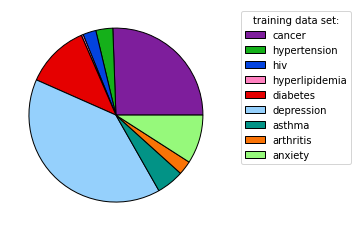

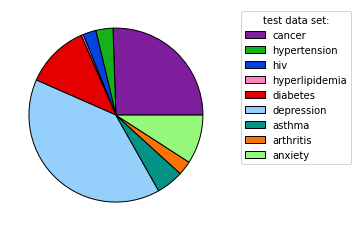

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

train_count = {disease: 0 for disease in diseases_list}
test_count = {disease: 0 for disease in diseases_list}

train_data = pd.read_csv(data_path + 'Train/train_before.csv')
for label in train_data['label']:
  train_count[label] +=15

test_data = pd.read_csv(data_path + 'Test/test_before.csv')

for label in test_data['label']:
  test_count[label] +=1


# define pie plots input value

x = np.array(list(train_count.values()))
# a list of colors to be assigned to each condition
my_colors = ['#7e1e9c','#15b01a','#0343df','#ff81c0','#e50000','#95d0fc','#029386','#f97306','#96f97b','#c20078']


fig1, ax1 = plt.subplots()
# define the plot
ax1.pie(x, labels=list(train_count.keys()), colors= my_colors, labeldistance= None, wedgeprops = {'edgecolor': 'black'})
# define legend
ax1.legend(title="training data set:",bbox_to_anchor=(1.05, 1), loc='upper left')


fig2, ax2 = plt.subplots()

x = np.array(list(test_count.values()))
# define the plot
ax2.pie(x, labels=list(test_count.keys()), colors= my_colors, labeldistance= None, wedgeprops = {'edgecolor': 'black'})
# define legend
ax2.legend(title="test data set:",bbox_to_anchor=(1.05, 1), loc='upper left')
# show the plot
plt.show()

## Train the Classifier for users tweets before detection date

In [ ]:
class Classifier:
  def __init__ (self, train_data_file_path, test_data_file_path):

    """
    train_data_dict{'username': [], 'label': [],' texts': [] }
    test_data_dict{'username': [], 'label': [],' texts': [] }

    """
    try:
      with open(train_data_path + 'train_before_normalized.pickle', 'rb') as train_file:
        self.train_data_dict = pickle.load(train_file)

    except FileNotFoundError:
      train_data = pd.read_csv(train_data_file_path)

      self.train_data_dict = {'username': list(), 'texts': list() ,'label': list()}
      for index, username in enumerate(train_data['username']):
        # combine users text into one string of tweets
        texts = self._combine_tweets(train_data['data'][index])

        if texts != '': # if its tweet after being normalized is not empty
          if index and index % 1000 == 0:
            print(index)
          self.train_data_dict['username'].append(username)
          self.train_data_dict['label'].append(train_data['label'][index])
          self.train_data_dict['texts'].append(texts)

      with open(train_data_path + 'train_before_normalized.pickle', 'wb') as train_file:
        pickle.dump(classifier.train_data_dict, train_file, protocol=pickle.HIGHEST_PROTOCOL)
    try:
      with open(test_data_path + 'test_before_normalized.pickle', 'rb') as test_file:
        self.test_data_dict = pickle.load(test_file)

    except FileNotFoundError:

      test_data = pd.read_csv(test_data_file_path)

      self.test_data_dict = {'username': list(), 'texts': list() ,'label': list()}
      for index, username in enumerate(test_data['username']):

        texts = self._combine_tweets(test_data['data'][index])
        if texts != '':   # if its tweet after being normalized is not empty
          if index and index % 1000 == 0:
            print(index)
          self.test_data_dict['username'].append(username)
          self.test_data_dict['label'].append(test_data['label'][index])
          self.test_data_dict['texts'].append(texts)

      with open(test_data_path + 'test_before_normalized.pickle', 'wb') as test_file:
        pickle.dump(classifier.test_data_dict, test_file, protocol=pickle.HIGHEST_PROTOCOL)

    # initial vectorizer and models
    self.vectorizer = TfidfVectorizer()
    self.feature_selector = SelectKBest(chi2, k=1000)
    self.LR_model = LogisticRegression(class_weight="balanced")
    self.SVC_model = SVC(class_weight="balanced")
    self.RF_model = RandomForestClassifier(n_estimators=11, class_weight='balanced', n_jobs=-1)
    self.lgbm_model = lgb.LGBMClassifier(boosting_type="dart", objective="multiclass",class_weight="balanced")

  def _combine_tweets(self, data):
    combined_text = ''
    data_dict = str_to_dict(data)

    for tweet in data_dict['text']:
      # only add the text if it was written in english
      try:
        # if detect(tweet) == 'en':
        combined_text += (self.normalize_tweet(tweet) + ' ')
      except:
        continue

    return combined_text

  def normalize_tweet(self, tweet):
      return (normalize_tweet(tweet))


  def fit_classifier(self, model= 'rf'):
    try:
      self.feature_vectors
    except:
      self.feature_vectors = self.vectorizer.fit_transform(self.train_data_dict["texts"])
      self.feature_vectors = self.feature_selector.fit_transform(self.feature_vectors, self.train_data_dict["label"])
    if model is 'rf':
      self.RF_model.fit(self.feature_vectors, self.train_data_dict["label"])
    elif model is 'svc':
      self.SVC_model.fit(self.feature_vectors, self.train_data_dict["label"])
    elif model is 'lr':
      self.LR_model.fit(self.feature_vectors, self.train_data_dict["label"])
    elif model is 'lgbm':
      self.lgbm_model.fit(self.feature_vectors, self.train_data_dict["label"])

  def predict(self, model = 'rf'):
    feature_vectors =self.vectorizer.transform(self.test_data_dict["texts"])
    feature_vectors = self.feature_selector.transform(feature_vectors)
    if model is 'rf':
      preds = self.RF_model.predict(feature_vectors)
      return preds
    elif model is 'svc':
      preds = self.SVC_model.predict(feature_vectors)
      return preds
    elif model is 'lr':
      preds = self.LR_model.predict(feature_vectors)
      return preds
    elif model is 'lgbm':
      preds = self.lgbm_model.predict(feature_vectors)
      return preds

  def evaluate(self, model = 'rf'):
    if model is 'rf':
      self.fit_classifier('rf')
      return classification_report(self.test_data_dict["label"],self.predict('rf'))

    elif model is 'svc':
      self.fit_classifier('svc')
      return classification_report(self.test_data_dict["label"],self.predict('svc'))
    elif model is 'lr':
      self.fit_classifier('lr')
      return classification_report(self.test_data_dict["label"],self.predict('lr'))

    elif model is 'lgbm':
      self.fit_classifier('lgbm')
      return classification_report(self.test_data_dict["label"], self.predict('lgbm'))

classifier = Classifier(data_path + 'Train/train_before.csv', data_path + 'Test/test_before.csv')

<>:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:86: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:88: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:90: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:96: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:99: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:102: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:105: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:110: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:114: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:117: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:121: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:86: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:88: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:90: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>

## a sample of normalized and altered data that is going to be used as an input for models

In [ ]:
classifier.train_data_dict["username"][0]

'Tropibrazuca'

In [ ]:
classifier.train_data_dict["label"][0]

'cancer'

In [ ]:
classifier.train_data_dict["texts"][0]

'dad passed away transitioned left funeral classes starting later term diagnosed cancer surgery took one week not reallyi canceled one class never rice beans polenta fried eggs crusty bread aged cheese salted dried fish pork peasant stock shows would polecats like clearly band name first album question  que lindo preciso voltar portugal familiar also familiar hundreds young people use term default debates latinx abound op wanted inclusive guess anyone rails new terminology calls sjws probably not get advice welcome applications urm candidates seek diverse pool candidates one person not get erase collectives not identify not get leave kids alone cocacola market value falls 4b cristiano ronaldo removes bottles water bleacher report congratulations @whaasstsecty julie chung indeedand get would love indoor cat not probably feral though possibly abandoned young rescued miami streets not indoor cat working itshe sleeps every night moved virginia florida cat moved lizards rodents many kinds r

# Classifiers

## Logisitic Regression

In [ ]:
classifier.fit_classifier(model= 'lr')
evaluation_metrics = classifier.evaluate(model= 'lr')
print(evaluation_metrics)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

                precision    recall  f1-score   support

       anxiety       0.43      0.46      0.45       183
     arthritis       0.47      0.53      0.50        53
        asthma       0.32      0.74      0.45       102
        cancer       0.81      0.73      0.77       452
    depression       0.65      0.52      0.58       403
      diabetes       0.86      0.61      0.71       238
           hiv       0.68      0.73      0.71        49
hyperlipidemia       0.50      0.25      0.33         8
  hypertension       0.29      0.50      0.36        64

      accuracy                           0.61      1552
     macro avg       0.56      0.56      0.54      1552
  weighted avg       0.66      0.61      0.62      1552



## SVC

In [ ]:
classifier.fit_classifier(model= 'svc')
evaluation_metrics = classifier.evaluate(model= 'svc')
print(evaluation_metrics)

                precision    recall  f1-score   support

       anxiety       0.39      0.48      0.43       183
     arthritis       0.47      0.51      0.49        53
        asthma       0.46      0.71      0.56       102
        cancer       0.85      0.76      0.80       452
    depression       0.64      0.61      0.63       403
      diabetes       0.90      0.70      0.79       238
           hiv       0.78      0.71      0.74        49
hyperlipidemia       0.00      0.00      0.00         8
  hypertension       0.30      0.44      0.35        64

      accuracy                           0.65      1552
     macro avg       0.53      0.55      0.53      1552
  weighted avg       0.68      0.65      0.66      1552



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest

In [ ]:
classifier.fit_classifier(model= 'rf')
evaluation_metrics = classifier.evaluate(model= 'rf')
print(evaluation_metrics)

                precision    recall  f1-score   support

       anxiety       0.56      0.39      0.46       183
     arthritis       0.83      0.85      0.84        53
        asthma       0.77      0.79      0.78       102
        cancer       0.86      0.90      0.88       452
    depression       0.70      0.83      0.76       403
      diabetes       0.87      0.88      0.87       238
           hiv       0.92      0.71      0.80        49
hyperlipidemia       0.00      0.00      0.00         8
  hypertension       0.79      0.42      0.55        64

      accuracy                           0.78      1552
     macro avg       0.70      0.64      0.66      1552
  weighted avg       0.77      0.78      0.77      1552



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LightGBM

In [ ]:
classifier.fit_classifier(model='lgbm')
evaluation_metrics = classifier.evaluate(model='lgbm')
print(evaluation_metrics)

                precision    recall  f1-score   support

       anxiety       0.61      0.63      0.62       183
     arthritis       0.82      0.94      0.88        53
        asthma       0.79      0.93      0.86       102
        cancer       0.94      0.90      0.92       452
    depression       0.82      0.76      0.79       403
      diabetes       0.94      0.93      0.93       238
           hiv       0.75      0.98      0.85        49
hyperlipidemia       0.86      0.75      0.80         8
  hypertension       0.68      0.69      0.68        64

      accuracy                           0.83      1552
     macro avg       0.80      0.84      0.81      1552
  weighted avg       0.84      0.83      0.83      1552

